#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

In [15]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,701 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123629 files and dire

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/project6/'

### **(2) 라이브러리 설치 및 불러오기**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [5]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

#### 2) 기본 정보 조회

In [6]:
print(sales.isna().sum())
sales.head()

Date          0
Store_ID      0
Qty           0
Product_ID    0
dtype: int64


,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7
3,2014-01-01,1,0.0,8
4,2014-01-01,1,0.0,10


In [7]:
print(products.isna().sum())
products.head()

Product_ID      0
Product_Code    0
SubCategory     0
Category        0
LeadTime        0
Price           0
dtype: int64


,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23
3,15,HK002,Kitchen,Household Goods,2,41
4,32,GS001,Seafood,Grocery,3,34


In [8]:
print(stores.isna().sum())
stores.head()

Store_ID      0
City          0
State         0
Store_Type    0
dtype: int64


,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4
3,4,Saint Paul,\tMinnesota,4
4,5,Oklahoma City,Oklahoma,4


In [9]:
print(orders.isna().sum())
orders.head()

Date             0
Store_ID         0
CustomerCount    0
dtype: int64


,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875
3,2014-01-02,2,2122
4,2014-01-02,3,3350


In [10]:
print(oil_price.isna().sum())
oil_price.head()

Date          0
WTI_Price    30
dtype: int64


,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31


# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이 33333333333
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발유 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [11]:
sales_44_3=sales[(sales['Store_ID']==44)&(sales['Product_ID']==3)]
sales_44_3['Year']=sales_44_3['Date'].dt.year
sales_44_3['Month']=sales_44_3['Date'].dt.month
sales_44_3

,Date,Store_ID,Qty,Product_ID,Year,Month
645,2014-01-01,44,0.0,3,2014,1
1456,2014-01-02,44,9853.0,3,2014,1
2267,2014-01-03,44,8647.0,3,2014,1
3078,2014-01-04,44,15153.0,3,2014,1
3889,2014-01-05,44,15606.0,3,2014,1
...,...,...,...,...,...,...
930865,2017-02-24,44,10208.0,3,2017,2
931676,2017-02-25,44,12361.0,3,2017,2
932487,2017-02-26,44,10108.0,3,2017,2
933298,2017-02-27,44,10006.0,3,2017,2


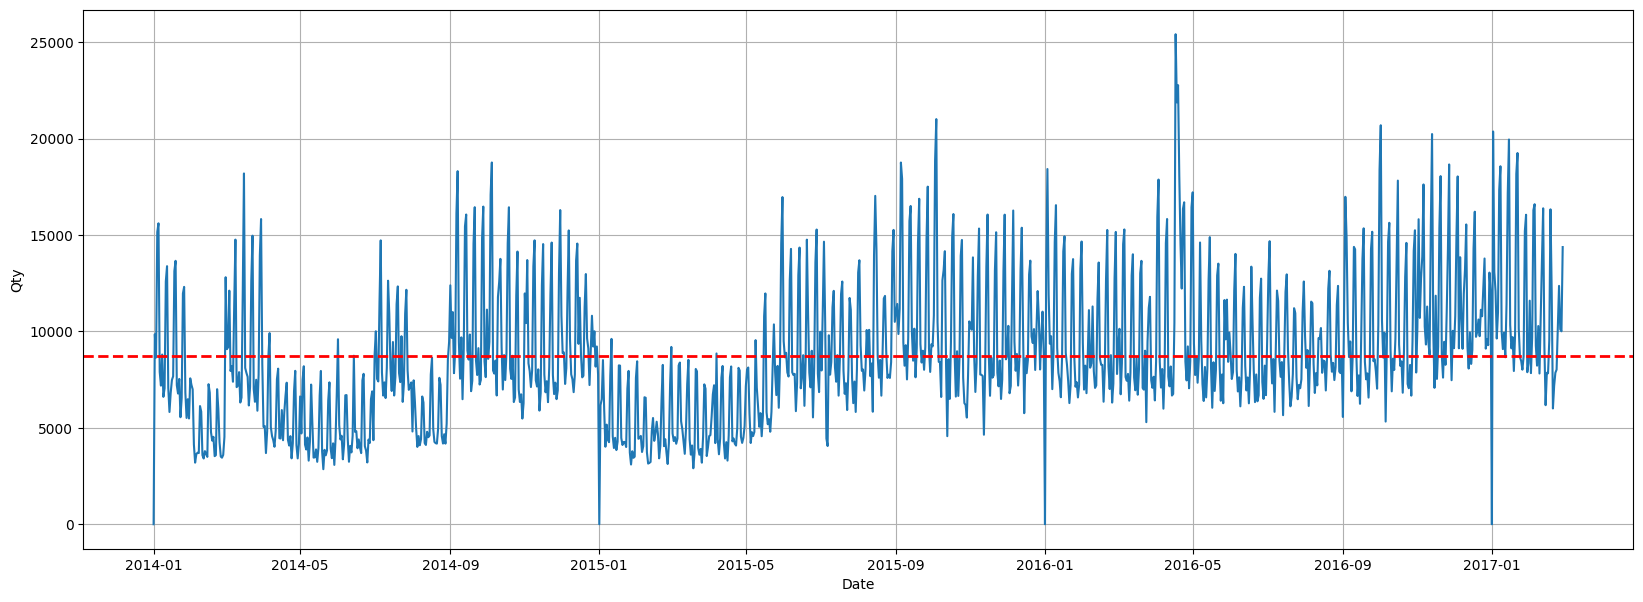

In [12]:
plt.figure(figsize=(20,7))
plt.plot(sales_44_3['Date'],sales_44_3['Qty'])
plt.xlabel('Date')
plt.ylabel('Qty')
plt.axhline(y=sales_44_3['Qty'].mean(), color='red', linestyle='--', linewidth=2)
plt.grid()
plt.show()
# 시간이 흐름에 따라 판매량이 증가하고 있다

### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [13]:
sales_products=pd.merge(sales,products,on='Product_ID',how='inner')
# sales_products=pd.merge(sales_products,orders,on='Store_ID',how='inner')
sales_products=sales_products[sales_products['Store_ID']==44]
sales_products['Weekday'] = sales_products['Date'].dt.day_name()
sales_products['years']=sales_products['Date'].dt.year
sales_products['Month']=sales_products['Date'].dt.month

sales_products

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,Weekday,years,Month
645,2014-01-01,44,0.000,3,DB001,Beverage,Drink,2,8,Wednesday,2014,1
646,2014-01-01,44,0.000,5,FB001,BAKERY,Food,2,6,Wednesday,2014,1
647,2014-01-01,44,0.000,7,HC001,Cleaning,Household Goods,2,15,Wednesday,2014,1
648,2014-01-01,44,0.000,8,FM001,Yogurt,Food,2,4,Wednesday,2014,1
649,2014-01-01,44,0.000,10,GE001,EGGS,Grocery,2,5,Wednesday,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...
934120,2017-02-28,44,1057.687,24,GM001,Meats,Grocery,3,17,Tuesday,2017,2
934121,2017-02-28,44,79.000,27,HH001,Home Appliances,Household Goods,2,150,Tuesday,2017,2
934122,2017-02-28,44,87.000,42,FM001,Agricultural products,Grocery,2,5,Tuesday,2017,2
934123,2017-02-28,44,607.427,29,FP001,Prepared,Food,2,18,Tuesday,2017,2


In [ ]:
drink=sales_products[sales_products['Category']=='Drink']


In [ ]:
drink['Product_ID'].unique()

array([ 3, 38])

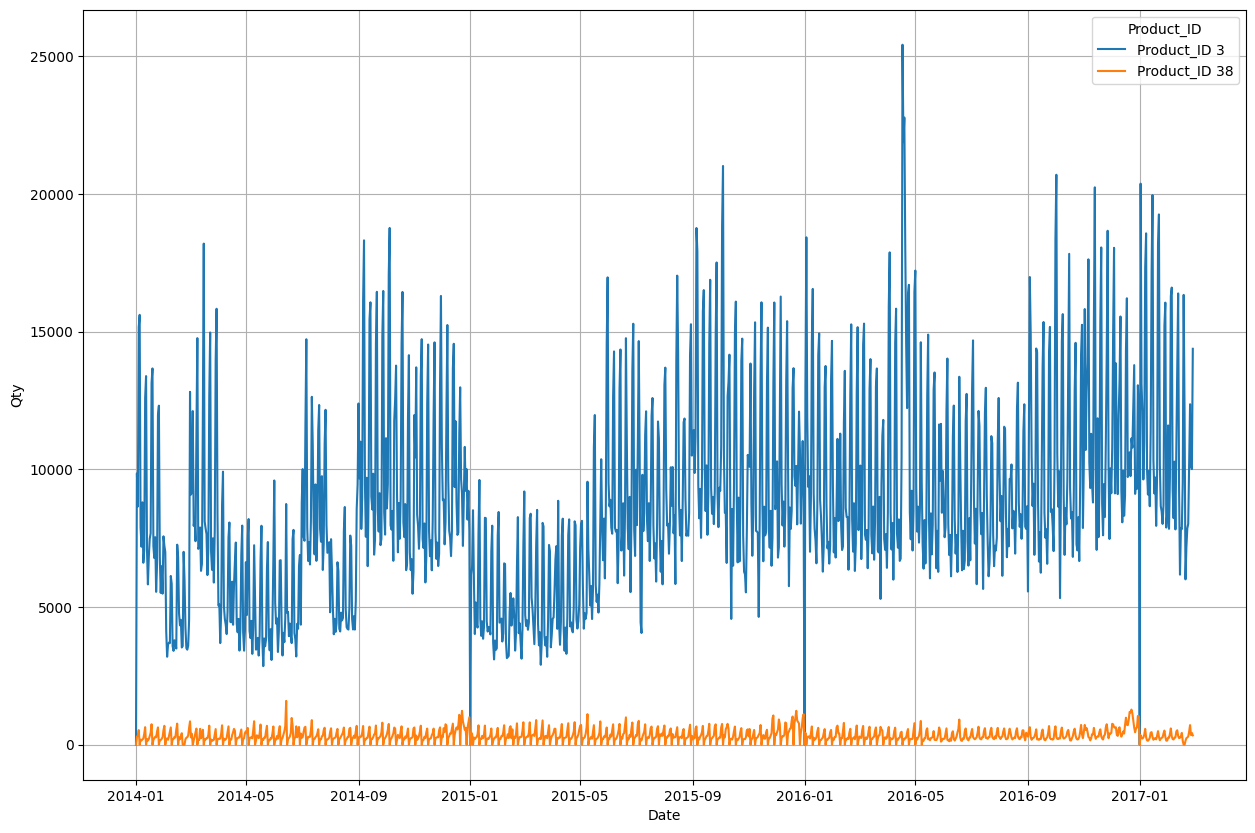

In [ ]:

plt.figure(figsize=(15,10))
for product_id in drink['Product_ID'].unique():
    product_data = drink[drink['Product_ID'] == product_id]
    plt.plot(product_data['Date'], product_data['Qty'], label=f'Product_ID {product_id}')


plt.xlabel('Date')
plt.ylabel('Qty')
plt.grid()
plt.legend(title='Product_ID')
plt.show()


### 3) 휘발유 가격과 상품 판매량 추이 비교

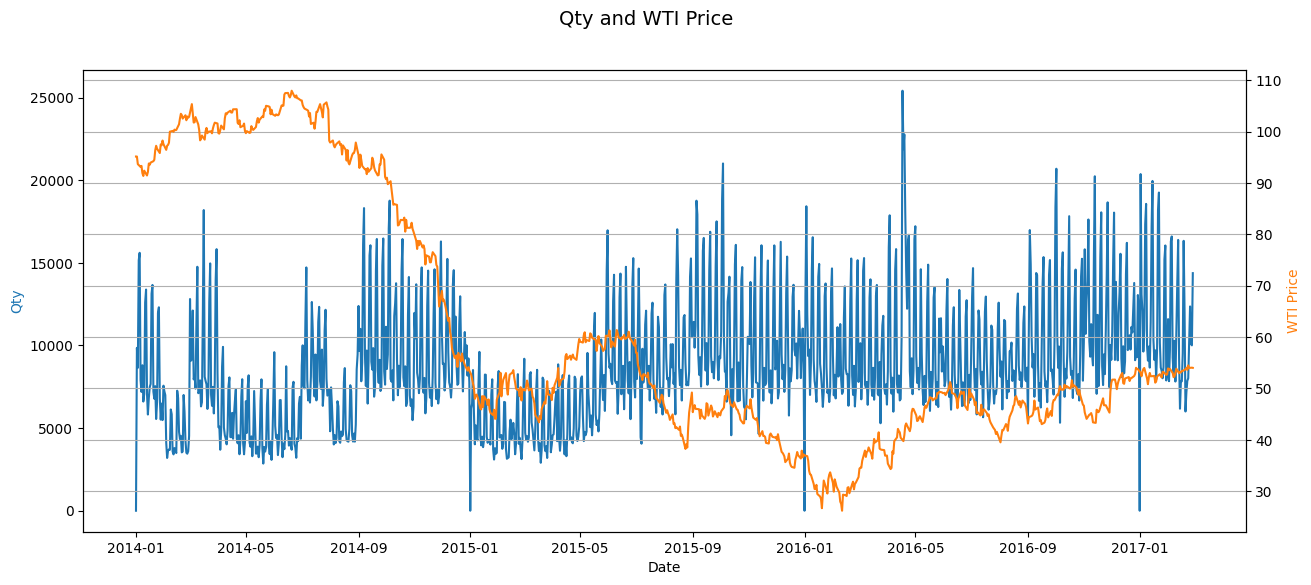

In [ ]:
# 결측치를 이전값과 이후값의 평균으로 채우기
oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
# 첫번째 또는 마지막 값이 결측치인 경우 이전/이후 값으로 채우기
oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='ffill').fillna(method='bfill')


fig, ax1 = plt.subplots(figsize=(15, 6))

# 첫번째 Qty
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty', color='tab:blue')
ax1.plot(sales_44_3['Date'], sales_44_3['Qty'], color='tab:blue', label='Qty')


# 두번째 WTI_Price
ax2 = ax1.twinx()  # 두 번째 y축 생성
ax2.set_ylabel('WTI Price', color='tab:orange')
ax2.plot(oil_price['Date'], oil_price['WTI_Price'], color='tab:orange', label='WTI Price')

fig.suptitle('Qty and WTI Price', fontsize=14)

plt.grid()
plt.show()


### 4) 방문 고객수와 상품 판매량 추이 비교

In [ ]:
orders_44=orders[orders['Store_ID']==44]
orders_44

,Date,Store_ID,CustomerCount
39,2014-01-02,44,4422
86,2014-01-03,44,4167
133,2014-01-04,44,5341
180,2014-01-05,44,5123
227,2014-01-06,44,3917
...,...,...,...
57336,2017-02-24,44,4549
57389,2017-02-25,44,4619
57442,2017-02-26,44,3877
57495,2017-02-27,44,3961


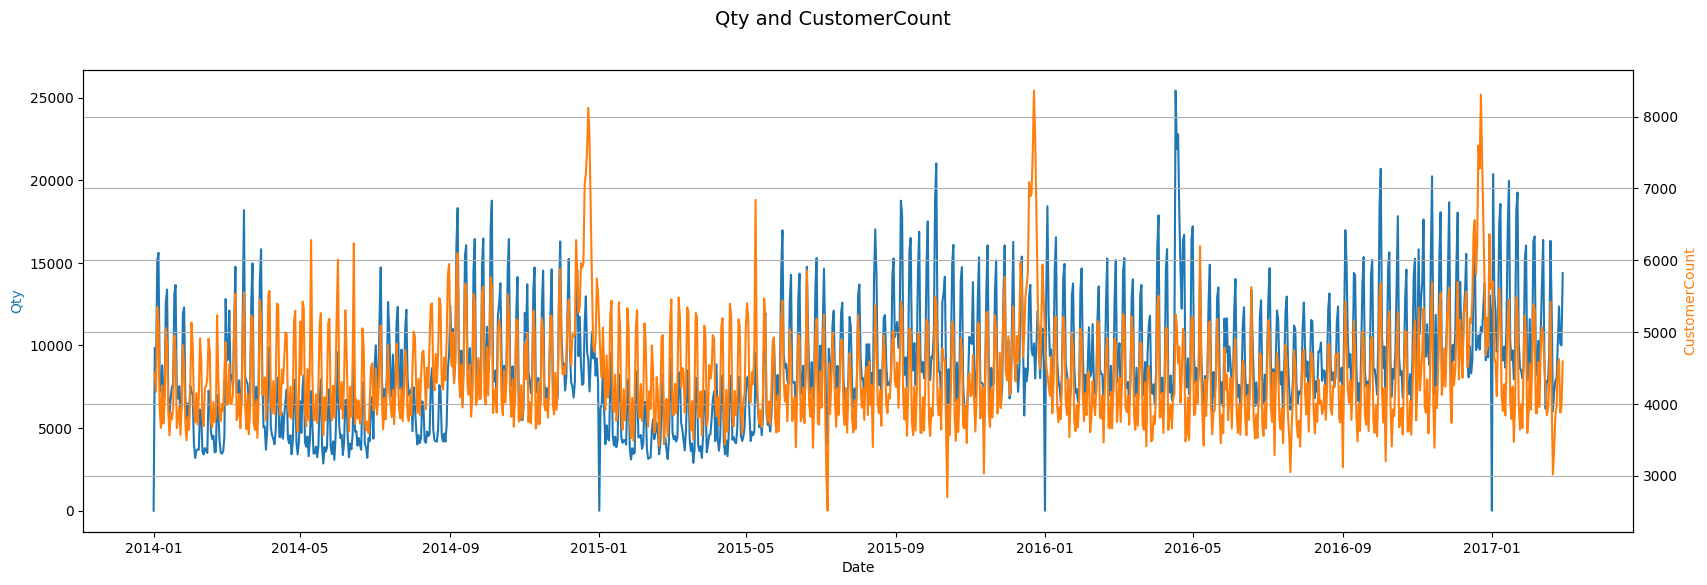

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 6))

# 첫번째 Qty
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty', color='tab:blue')
ax1.plot(sales_44_3['Date'], sales_44_3['Qty'], color='tab:blue', label='Qty')


# 두번째 WTI_Price
ax2 = ax1.twinx()  # 두 번째 y축 생성
ax2.set_ylabel('CustomerCount', color='tab:orange')
ax2.plot(orders['Date'], orders['CustomerCount'], color='tab:orange', label='CustomerCount')

fig.suptitle('Qty and CustomerCount', fontsize=14)

plt.grid()
plt.show()


## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 대상 매장(44), 대상 상품의 판매량 추이

### 2) 요일별 변화량 비교

In [ ]:
# 요일 데이터 추가(0:월요일 6:일요일)
orders_44['Weekday'] = orders_44['Date'].dt.day_name()
orders_44['years']=orders_44['Date'].dt.year
orders_44['Month']=orders_44['Date'].dt.month
orders_44

,Date,Store_ID,CustomerCount,Weekday,years,Month
39,2014-01-02,44,4422,Thursday,2014,1
86,2014-01-03,44,4167,Friday,2014,1
133,2014-01-04,44,5341,Saturday,2014,1
180,2014-01-05,44,5123,Sunday,2014,1
227,2014-01-06,44,3917,Monday,2014,1
...,...,...,...,...,...,...
57336,2017-02-24,44,4549,Friday,2017,2
57389,2017-02-25,44,4619,Saturday,2017,2
57442,2017-02-26,44,3877,Sunday,2017,2
57495,2017-02-27,44,3961,Monday,2017,2


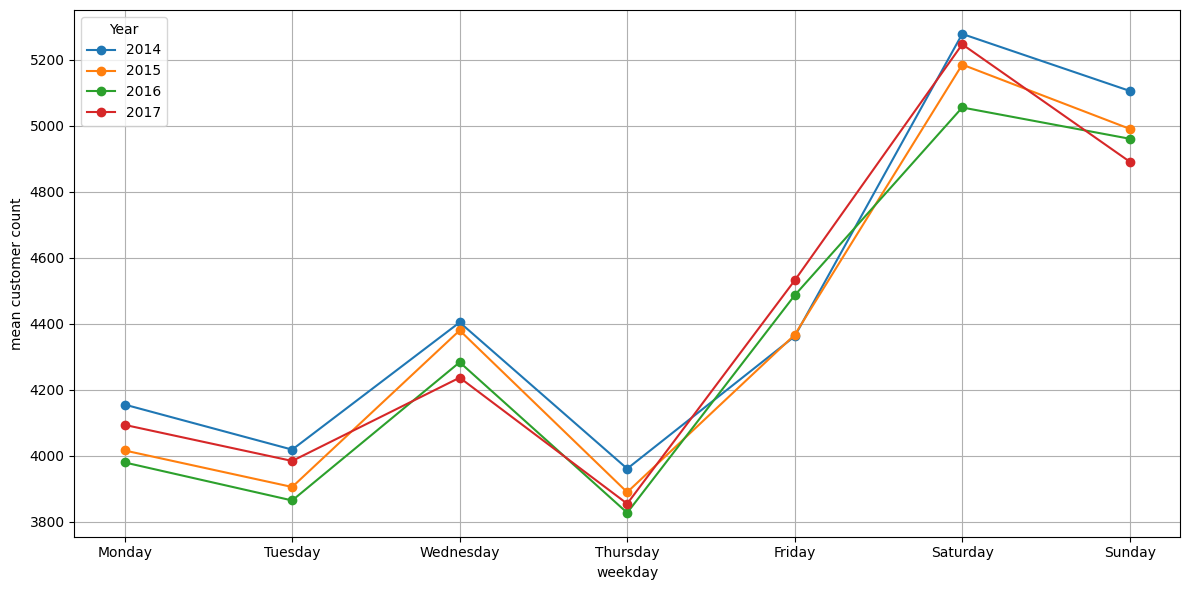

In [ ]:
# 연도별 요일에 따른 방문자수 추이 비교

# 연도와 요일별로 그룹화하여 평균 방문자 수 계산
pivot_df = orders_44.groupby(['years', 'Weekday'])['CustomerCount'].mean().unstack()

# 요일 순서 지정
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df[weekday_order]

# 그래프 그리기
plt.figure(figsize=(12, 6))
for year in pivot_df.index:
    plt.plot(weekday_order, pivot_df.loc[year], marker='o', label= year)

# 그래프 설정
plt.xlabel('weekday')
plt.ylabel('mean customer count')
plt.legend(title='Year')
plt.grid()
plt.tight_layout()
plt.show()

# 1.금토일이 마트 방문자수가 많다

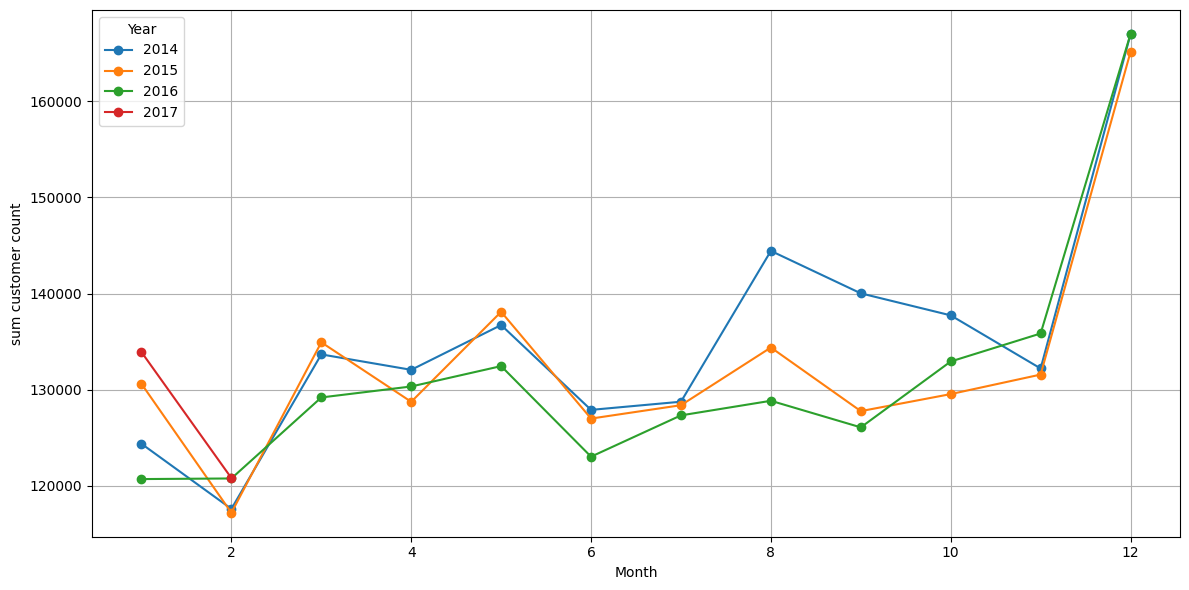

In [ ]:
# 연도와 월별 방문자수 추이 비교

# 연도와 월별로 그룹화하여 총 방문자 수 계산
pivot_df = orders_44.groupby(['years', 'Month'])['CustomerCount'].sum().unstack()

# 월별 순서 지정
month_order = [1,2,3,4,5,6,7,8,9,10,11,12]
pivot_df = pivot_df[month_order]

# 그래프 그리기
plt.figure(figsize=(12, 6))
for year in pivot_df.index:
    plt.plot(month_order, pivot_df.loc[year], marker='o', label=year)

# 그래프 설정
plt.xlabel('Month')
plt.ylabel('sum customer count')
plt.legend(title='Year')
plt.grid()
plt.tight_layout()
plt.show()

# 12월달은 많은 고객들이 가게에 많이 방문하고 내후련 1월에 급격히 감소한다

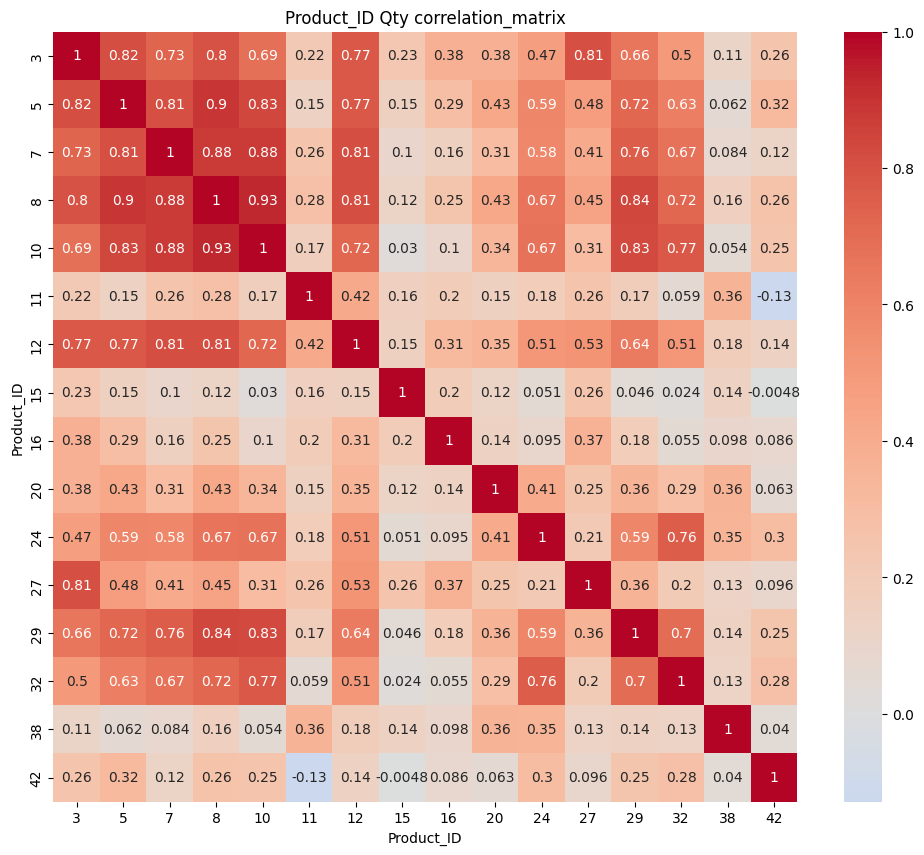

In [ ]:
# 피벗 테이블 생성
# Date를 인덱스로, Product_ID를 열로, Qty를 값으로 하는 피벗 테이블 생성
pivot_df = sales_products.pivot_table(index='Date', columns='Product_ID', values='Qty', aggfunc='sum')


# 결측치(NaN)를 0으로 채움
pivot_df = pivot_df.fillna(0)

# Product_ID 간의 상관계수 계산
correlation_matrix = pivot_df.corr()

# 상관계수 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Product_ID Qty correlation_matrix')
plt.xlabel('Product_ID')
plt.ylabel('Product_ID')
plt.show()

[링크 텍스트](https://)

In [ ]:
# 3-> 5 27 8 12 7 강한 상관관계를 확인해 봤다

sales_products[sales_products['Product_ID']==5] # BAKERY	Food
sales_products[sales_products['Product_ID']==27] #Home Appliances	Household Goods
sales_products[sales_products['Product_ID']==8] #Yogurt	Food
sales_products[sales_products['Product_ID']==12] #Milk	Food
sales_products[sales_products['Product_ID']==7] #Cleaning	Household Goods
sales_products[sales_products['Product_ID']==10] #EGGS	Grocery

# 제품 카테고리를 확인해 봤을때 3(음료)를 구매하시는 구매목록은 가정용품과 식료품으로 여성고객들이 많을것이라 예상한다.

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,Weekday,years,Month
645,2014-01-01,44,0.0,3,DB001,Beverage,Drink,2,8,Wednesday,2014,1
1456,2014-01-02,44,9853.0,3,DB001,Beverage,Drink,2,8,Thursday,2014,1
2267,2014-01-03,44,8647.0,3,DB001,Beverage,Drink,2,8,Friday,2014,1
3078,2014-01-04,44,15153.0,3,DB001,Beverage,Drink,2,8,Saturday,2014,1
3889,2014-01-05,44,15606.0,3,DB001,Beverage,Drink,2,8,Sunday,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...
930865,2017-02-24,44,10208.0,3,DB001,Beverage,Drink,2,8,Friday,2017,2
931676,2017-02-25,44,12361.0,3,DB001,Beverage,Drink,2,8,Saturday,2017,2
932487,2017-02-26,44,10108.0,3,DB001,Beverage,Drink,2,8,Sunday,2017,2
933298,2017-02-27,44,10006.0,3,DB001,Beverage,Drink,2,8,Monday,2017,2


### 3) 시계열 데이터 분해

In [ ]:
def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

### 4) 그 외 패턴 찾아보기

# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.

In [ ]:
# ![image.png]()

[링크 텍스트](https://))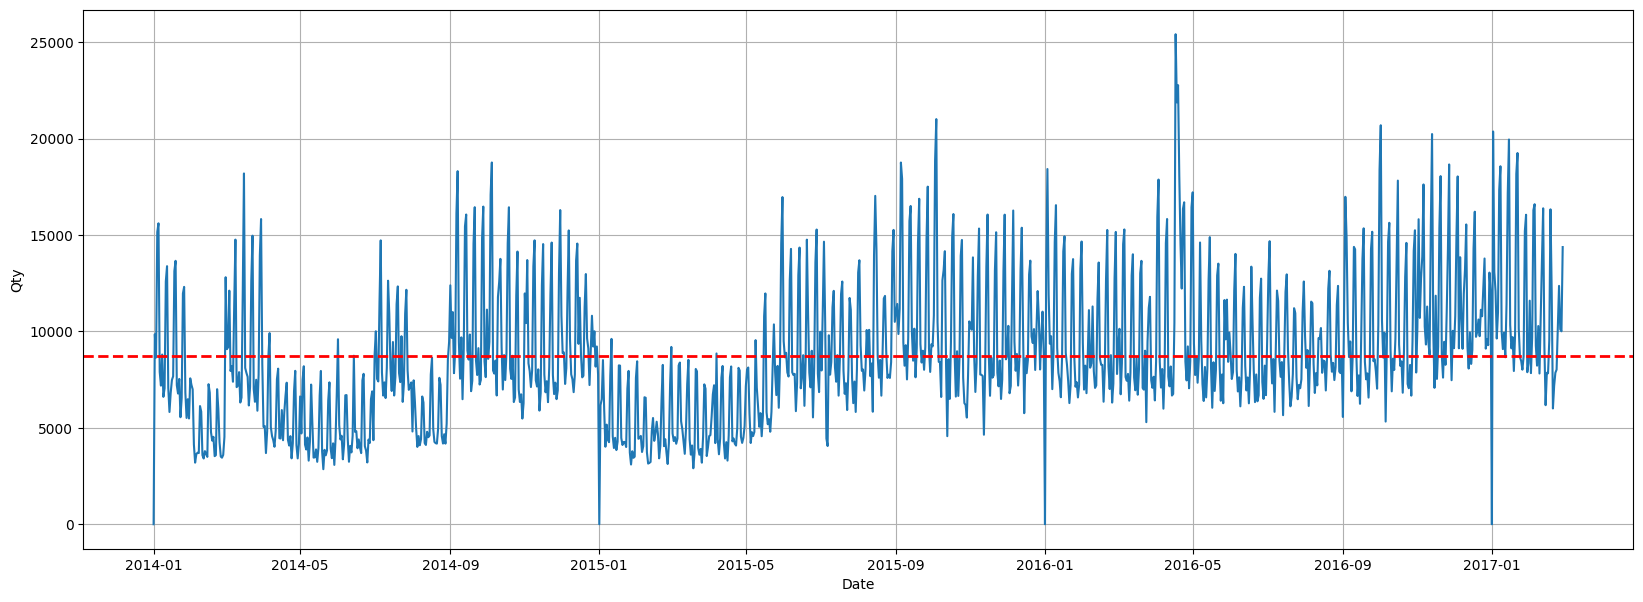

**목적**
- 대상상품(3) 판매량 추이를 확인해 보기 위함

**특징**
- 전체 평균을 기준으로 년도가 바뀜에 따라 판매량이 증가하고있다

**결론**
- 점차 판매량이 증가하는 추세를 보이기 때문에 유통물량에 변화가 필요하다 생각함


[링크 텍스트](https://)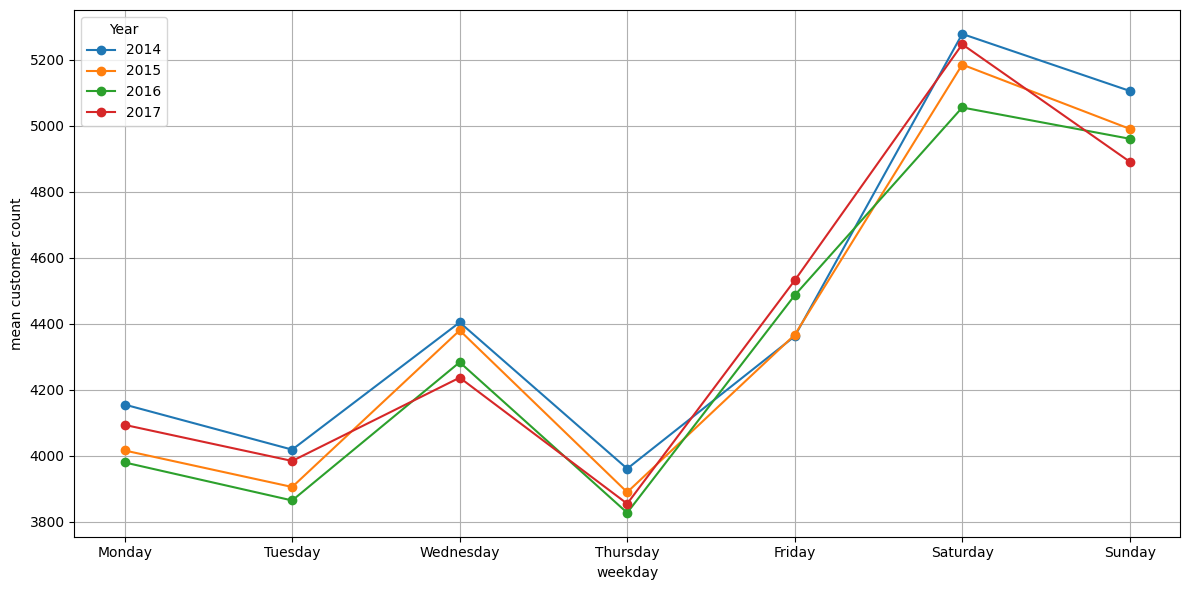

**목적**
- 연도별 요일에 따른 방문자수 평균을 확이해 보고 제품 공급량을 결정하려고 한다

**특징**
- 금,토,일 마트 방문자수가 많다
- 월,화요일에 방문자수가 감소하다가 수요일에 증가하는 모습을 보인다

**결론**
- 화요일에 상품공급을 줄이고 목요일에 상품공급을 늘리는게 좋아보임


[링크 텍스트](https://)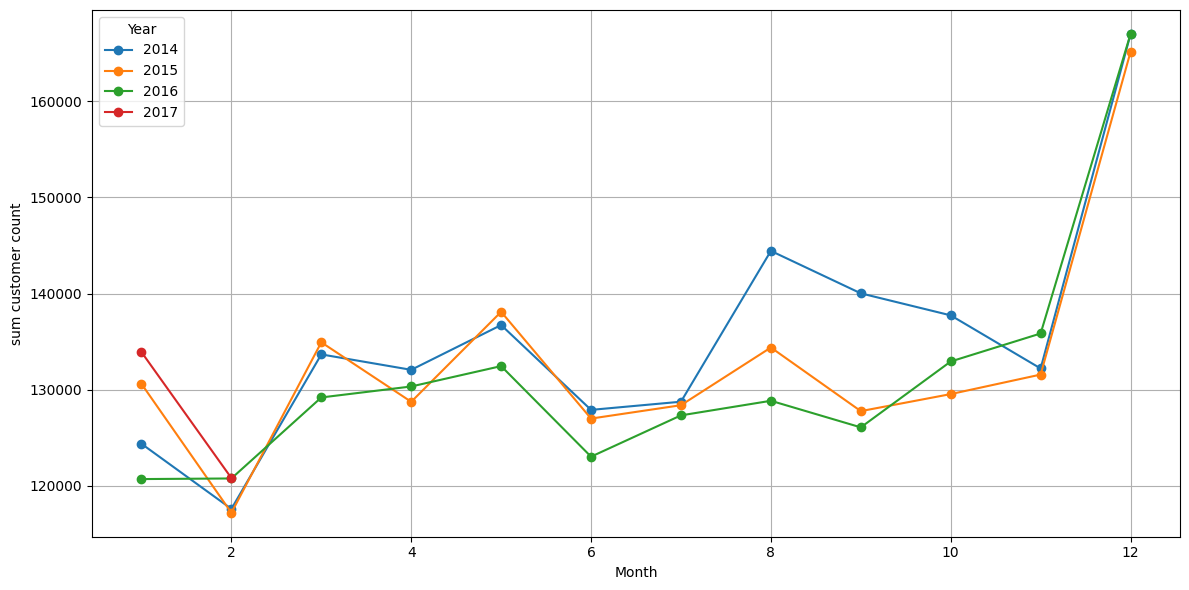

**목적**
- 년도에 따라 대상상품(3)을 구매하러 매장으로 방문하는 고객데이터를 월별 확인해 보고자 함

**특징**
- 12월이 다른월에 비해 대상상품(3)을 구매하러오는 고객수가 월등히 많다


**결론**
- 대상상품(3) 공급을 12월달에 치중할 필요가 있다


[링크 텍스트](https://)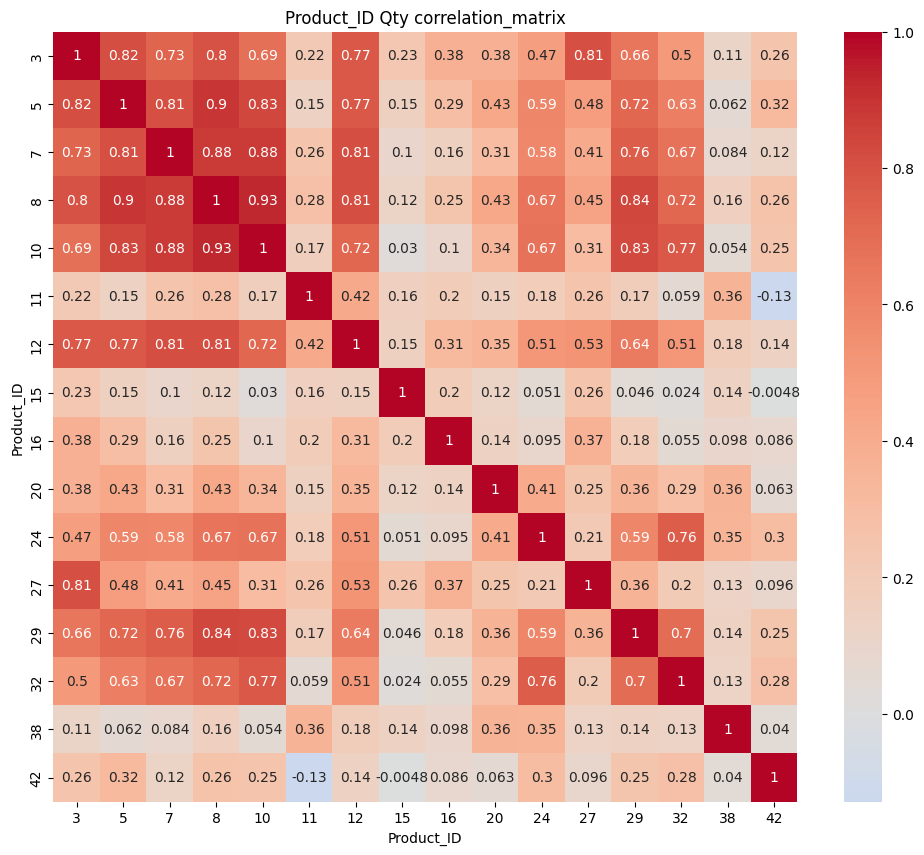



**목적**
- 대상상품(3)을 구매하러 오는 고객들은 주로 무엇을 구매하나 확인하기 위해 상관관계 그래프를 확인해 봤다

**특징**
- 제품 카테고리를 확인해 봤을때 대상상품3(음료)를 구매하시는 구매목록은 가정용품과 식료품을 많이 구매하는 고객으로 확인된다

**결론**
- 구매 물품으로 고객을 유추해보면 여성고객(주부)일 확률이 높을것 같음 따라서 여성고객(주부)을 대상으로 한 기획이 필요하다 생각된다